# Tow_matters PiCar

In [24]:
import os
import fnmatch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from natsort import natsorted

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten,Dropout, BatchNormalization, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import regularizers
from tensorflow_addons.metrics import RSquare
from imgaug import augmenters as img_aug

import warnings
import random
import cv2
import pickle
import requests
import time

#from pushover import Client

warnings.filterwarnings('ignore')

In [43]:
# Code to send notification to my phone

class PushoverCallback(tf.keras.callbacks.Callback):
    def __init__(self, client, title, sound, interval):
        super(PushoverCallback, self).__init__()
        self.client = client
        self.title = title
        self.sound = sound
        self.interval = interval

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.interval == 0:
            message = f"Epoch {epoch + 1}: val_loss={logs['val_loss']:.4f}"
            self.client.send_message(message, title=self.title, sound=self.sound)

class TimeoutMonitor(tf.keras.callbacks.Callback):
    def __init__(self, client, title, sound, timeout=300):
        super(TimeoutMonitor, self).__init__()
        self.client = client
        self.title = title
        self.sound = sound
        self.timeout = timeout
        self.start_time = None

    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        pass

    def on_epoch_begin(self, epoch, logs=None):
        if self.start_time is not None and (time.time() - self.start_time) > self.timeout:
            message = f"Training has not moved to the next epoch after {self.timeout} seconds"
            self.client.send_message(message, title=self.title, sound=self.sound)
            self.start_time = time.time()

pushover_api_token = 'a3vns7mdqta4mbp42eeqb1ymo6ear5'
pushover_user_key = 'u5c3e3f58nrkui6dpuk5njcpfigxie'
client = Client(pushover_user_key, api_token=pushover_api_token)

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]) # Notice here
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

In [2]:
# Load csv file 
df = pd.read_csv('../datasets/PiCar/training_norm.csv', index_col=False)
df.head()

,image_id,angle,speed
0,1,0.4375,0.0
1,2,0.8125,1.0
2,3,0.4375,1.0
3,4,0.6250,1.0
4,5,0.5000,0.0


In [3]:
df.shape

(13793, 3)

In [4]:
#df = df.drop('image_id', axis=1)
#df.head()

In [5]:
df['angle'].value_counts()

0.7500    2123
0.5000    2046
0.6875    2007
0.6250    1963
0.5625    1609
0.4375    1467
0.8125    1147
0.3750     428
0.8750     301
0.3125     213
0.2500     104
0.1250      99
0.1875      98
0.9375      65
0.0000      60
1.0000      35
0.0625      28
Name: angle, dtype: int64

In [6]:
a = df['image_id'].tolist()
b = [x for x in range(a[0], a[-1] + 1)]
missing_vals = list(set(a) ^ set(b))
print('Missing data:', missing_vals)

Missing data: [3141, 3999, 4895, 8285, 10171]


In [7]:
images_dir = '../datasets/PiCar/train/training_data'
file_list = os.listdir(images_dir)
image_paths = []
pattern = "*.png"

for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(images_dir,filename))

image_paths = natsorted(image_paths)
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data/3141.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data/3999.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data/4895.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data/8285.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data/10171.png']

image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data\\3141.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data\\3999.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data\\4895.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data\\8285.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data\\10171.png']

images = pd.DataFrame (image_paths, columns = ['images'])
images.describe()

,images
count,13793
unique,13793
top,../datasets/PiCar/train/training_data/5687.png
freq,1


In [8]:
df_all = pd.concat([df, images], axis=1)
df_all = df_all.drop('image_id', axis=1)
df_all = df_all.drop('angle', axis=1)
df_all.tail()

,speed,images
13788,1.0,../datasets/PiCar/train/training_data/13794.png
13789,1.0,../datasets/PiCar/train/training_data/13795.png
13790,0.0,../datasets/PiCar/train/training_data/13796.png
13791,0.0,../datasets/PiCar/train/training_data/13797.png
13792,1.0,../datasets/PiCar/train/training_data/13798.png


In [9]:
df_all.shape

(13793, 2)

In [10]:
#le = LabelEncoder()
#df_all['angle']= le.fit_transform(df_all['angle'])
#df_all.head()

image_path: ../datasets/PiCar/train/training_data/11.png
Speed: 0.0


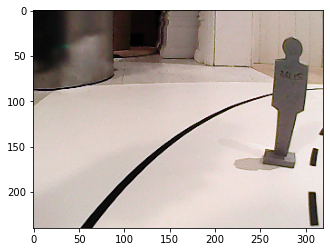

In [11]:
image_paths = df_all['images'].tolist()
speed = df_all['speed'].tolist()
image_index = 10
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index])
print("Speed:", speed[image_index]) 


(240, 320, 3)


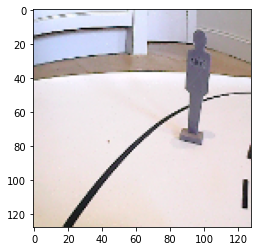

In [12]:
test_image = cv2.imread(df_all['images'][6])
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
print(test_image.shape)
test_image = cv2.resize(test_image, (128,128))
plt.imshow(test_image)
plt.show()

In [13]:
X_train, X_valid = train_test_split( df_all, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

Training data: 11034
Validation data: 2759


In [16]:
def zoom(image):
    zoom = img_aug.Affine(scale=(1, 1.2))  # zoom from 100% (no zoom) to 120%
    image = zoom.augment_image(image)
    return image

def pan(image):
    # pan left / right / up / down about 10%
    pan = img_aug.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

def adjust_brightness(image):
    # increase or decrease brightness by 30%
    brightness = img_aug.Multiply((0.7, 1.3))
    image = brightness.augment_image(image)
    return image

def blur(image):
    kernel_size = random.randint(1, 3)  # kernel larger than 5 would make the image way too blurry
    image = cv2.blur(image,(kernel_size, kernel_size))
    return image

def random_augment(image):
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = blur(image)
    if np.random.rand() < 0.5:
        image = adjust_brightness(image)
    return image

In [17]:
def random_flip(image):
    is_flip = random.randint(0, 1)
    if is_flip == 1:
        image = cv2.flip(image,1)
    return image, is_flip

In [18]:
def custom_generator(df, batch_size, target_size, is_training):
    while True:
        # Shuffle the data
        df = df.sample(frac=1).reset_index(drop=True)
        for i in range(0, len(df), batch_size):
            batch = df[i:i+batch_size]
            # Load images and labels
            images = []
            speeds = []
            for _, row in batch.iterrows():
                img = cv2.imread(row['images'])
                speed = row['speed']

                if is_training:
                    img = random_augment(img)
                    img, is_flip = random_flip(img)

                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, target_size)

                images.append(img)
                speeds.append(speed)

            # Normalize images
            images = np.array(images) / 255.0
            speeds = np.array(speeds)
            yield images, speeds

In [19]:
from tensorflow.keras.applications import VGG16

class Nvidia_CNN(tf.keras.Model):
  def __init__(self):
    super().__init__()

    self.vgg = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    self.conv1 = Conv2D(64, 3, strides=(2, 2), activation='relu')

    self.flatten = Flatten()
    self.d1 = Dense(100, activation='relu')
    self.d2 = Dense(50, activation='relu')
    self.d3 = Dense(10, activation='relu')
    self.d4 = Dense(5, activation='relu')

    self.Y1 = Dense(1, activation='sigmoid')

  def call(self, x):
    x = self.vgg(x)
    x = self.conv1(x)

    x = self.flatten(x)
    x = self.d1(x)
    x = self.d2(x)
    x = self.d3(x)
    x = self.d4(x)

    y1 = self.Y1(x)

    return y1

In [34]:
model = Nvidia_CNN()
model.build((1,224, 224, 3))
model.summary()

Model: "nvidia_cnn_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d_7 (Conv2D)           multiple                  294976    
                                                                 
 flatten_7 (Flatten)         multiple                  0         
                                                                 
 dense_35 (Dense)            multiple                  57700     
                                                                 
 dense_36 (Dense)            multiple                  5050      
                                                                 
 dense_37 (Dense)            multiple                  510       
                                                                 
 dense_38 (Dense)            multiple                 

In [20]:
tf.keras.backend.clear_session()

# Early stop added
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
#pushover_callback = PushoverCallback(client=client, title='Model Training Update', sound='cashregister', interval=3)
#timeout_callback = TimeoutMonitor(client=client, title='Training Stuck!!!!!!!!', sound='falling')


train_gen = custom_generator(X_train, batch_size=32 ,target_size=(224, 224), is_training= True)
val_gen = custom_generator(X_valid, batch_size=32, target_size=(224, 224), is_training= False)

model = Nvidia_CNN()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
                    metrics = 'accuracy')

history = model.fit(train_gen,
                    steps_per_epoch=len(X_train) // 32,
                    validation_data=val_gen,
                    validation_steps=len(X_valid) // 32,
                    callbacks=[callback],
                    epochs=60)

model.save('model/Nvidia_CNN_speed',save_format='tf')

history_path = os.path.join('history_speed.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)

58889256/58889256 [==============================] - 19s 0us/step
Epoch 1/60
344/344 [==============================] - 3615s 11s/step - loss: 0.1696 - accuracy: 0.9335 - val_loss: 0.1442 - val_accuracy: 0.9484
Epoch 2/60
344/344 [==============================] - 3597s 10s/step - loss: 0.1033 - accuracy: 0.9609 - val_loss: 0.0742 - val_accuracy: 0.9738
Epoch 3/60
344/344 [==============================] - 3581s 10s/step - loss: 0.0765 - accuracy: 0.9700 - val_loss: 0.0735 - val_accuracy: 0.9691
Epoch 4/60
344/344 [==============================] - 3583s 10s/step - loss: 0.0728 - accuracy: 0.9726 - val_loss: 0.0798 - val_accuracy: 0.9717
Epoch 5/60
344/344 [==============================] - 3558s 10s/step - loss: 0.0636 - accuracy: 0.9772 - val_loss: 0.0573 - val_accuracy: 0.9786
Epoch 6/60
344/344 [==============================] - 3618s 11s/step - loss: 0.0610 - accuracy: 0.9788 - val_loss: 0.0598 - val_accuracy: 0.9818
Epoch 7/60
344/344 [==============================] - 3550s 10s/

INFO:tensorflow:Assets written to: model/Nvidia_CNN_speed/assets


INFO:tensorflow:Assets written to: model/Nvidia_CNN_speed/assets


In [24]:
history_path = os.path.join('history_speed.pickle')
with open(history_path, 'rb') as f:
    history = pickle.load(f)

def plots(history):
    # summarize history for accuracy
    fig,  (ax2,ax4) = plt.subplots(1, 2, sharex=True, figsize=(10,6))

    ax2.set_title('Speed Accuracy')
    ax2.plot(history['accuracy'])
    ax2.plot(history['val_accuracy'])
    ax2.set_yscale('log')
    ax2.legend(['train', 'test'], loc='lower right')
    
    # summarize history for loss
    ax4.set_title('Speed loss')
    ax4.plot(history['loss'])
    ax4.plot(history['val_loss'])
    ax4.set_yscale('log')
    ax4.legend(['train', 'test'], loc='upper right')
    plt.show()

    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    

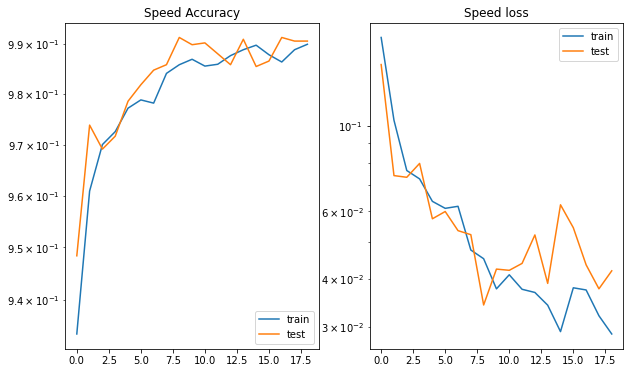

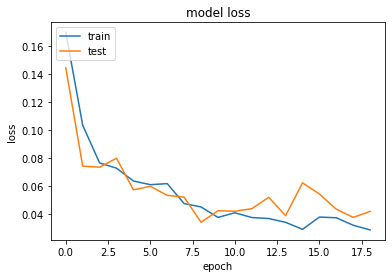

In [25]:
plots(history)

## Evaluation using validation set

In [14]:
def validation_generator(df, batch_size, target_size):
    while True:

        for i in range(0, len(df), batch_size):
            batch = df
            # Load images and labels
            images = []
            for _, row in batch.iterrows():
                img = cv2.imread(row['images'])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, target_size)
                images.append(img)

            images = np.array(images) / 255.0

            yield images

In [15]:
from keras.models import load_model
model = load_model('model/Nvidia_CNN_speed')
valgen = next(validation_generator(X_valid, batch_size=2759, target_size=(224, 224)))
predict = model.predict(valgen)
print(predict)

87/87 [==============================] - 205s 2s/step
[[0.99999905]
 [1.        ]
 [0.99998885]
 ...
 [0.99999374]
 [0.9999926 ]
 [0.99999106]]


In [18]:
#angles = pd.DataFrame(predict_val[0], columns=['Angle'])
pred_df = pd.DataFrame(predict, columns=['speed'])
#pred_df = pd.concat([angles, speed],axis=1)
pred_df.insert(0,"image_id", np.arange(1,len(pred_df)+1))

pred_df.head()

,image_id,speed
0,1,0.999999
1,2,1.000000
2,3,0.999989
3,4,0.999990
4,5,0.999999


In [19]:
pred_df.shape

(2759, 2)

In [20]:
pred_df_rnd = pred_df.round({'speed': 0})
pred_df_rnd.head()

,image_id,speed
0,1,1.0
1,2,1.0
2,3,1.0
3,4,1.0
4,5,1.0


In [21]:
pred_df_rnd['speed'] = pd.to_numeric(pred_df_rnd['speed'],downcast="integer" )
pred_df_rnd.head()

,image_id,speed
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [22]:
X_valid['speed']=X_valid['speed'].astype("int")
X_valid.head()

,speed,images
13758,1,../datasets/PiCar/train/training_data/13764.png
917,1,../datasets/PiCar/train/training_data/918.png
12850,1,../datasets/PiCar/train/training_data/12856.png
1723,1,../datasets/PiCar/train/training_data/1724.png
623,1,../datasets/PiCar/train/training_data/624.png


In [25]:
cm = confusion_matrix(X_valid['speed'], pred_df_rnd['speed'])

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       671
           1       0.99      1.00      1.00      2088

    accuracy                           0.99      2759
   macro avg       0.99      0.99      0.99      2759
weighted avg       0.99      0.99      0.99      2759



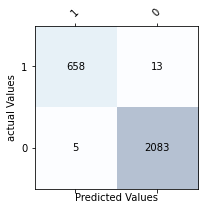

In [26]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(3,3))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i,j], va='center', ha='center')
classes=["1", "0"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values',)
plt.ylabel('actual Values',);
print(classification_report(X_valid['speed'], pred_df_rnd['speed']))

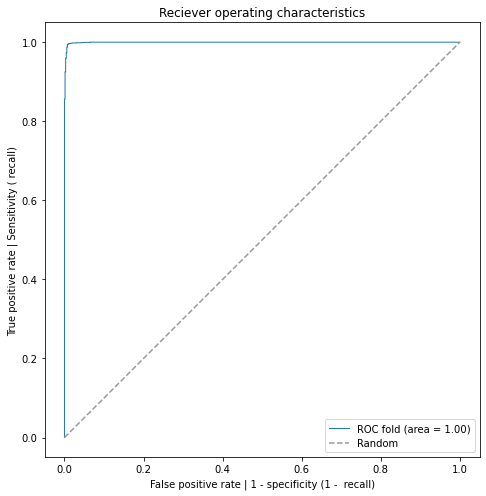

In [27]:
# Plot the rciever opertaing characteristic curve (ROC)
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10,8))
#probas_ = model.predict(X_valid['speed'])
fpr, tpr, thresholds = roc_curve(X_valid['speed'], pred_df['speed'])
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr, lw=1, label='ROC fold (area = %0.2f)' %(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate | 1 - specificity (1 -  recall)')
plt.ylabel('True positive rate | Sensitivity ( recall)')
plt.title('Reciever operating characteristics')
plt.legend(loc="lower right")
plt.axes().set_aspect(1);

## Final testing

In [63]:
images_dir = '../datasets/PiCar/test'
file_list = os.listdir(images_dir)
image_paths = []
pattern = "*.png"

for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(images_dir,filename))

image_paths = natsorted(image_paths)

images = pd.DataFrame (image_paths, columns = ['images'])
images.describe()

,images
count,1020
unique,1020
top,../datasets/PiCar/test\1.png
freq,1


In [64]:
def test_generator(df, batch_size, target_size):
    while True:

        for i in range(0, len(df), batch_size):
            batch = df
            # Load images and labels
            images = []
            for _, row in batch.iterrows():
                img = cv2.imread(row['images'])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, target_size)
                images.append(img)

            images = np.array(images) / 255.0

            yield images

In [65]:
from keras.models import load_model
model = load_model('model/Nvidia_CNN_speed')
testgen = next(test_generator(images, batch_size=1020, target_size=(224, 224)))
predict = model.predict(testgen)
print(predict)

32/32 [==============================] - 3s 75ms/step
[[1.3269458e-07]
 [9.9999988e-01]
 [9.9892384e-01]
 ...
 [9.9999988e-01]
 [9.9799037e-01]
 [9.9877816e-01]]


In [66]:
speed = pd.DataFrame(predict, columns=['speed'])
pred_df = pd.concat([speed],axis=1)
pred_df.insert(0,"image_id", np.arange(1,len(pred_df)+1))

pred_df.head()

,image_id,speed
0,1,1.326946e-07
1,2,9.999999e-01
2,3,9.989238e-01
3,4,9.993790e-01
4,5,9.997393e-01


In [67]:
pred_df = pred_df.round({'speed': 0})
pred_df.head()

,image_id,speed
0,1,0.0
1,2,1.0
2,3,1.0
3,4,1.0
4,5,1.0


In [68]:
pred_df.to_csv('Tow_mat4.csv', index=False)

In [35]:
test = next(custom_generator(X_valid, batch_size=10, target_size=(224, 224), is_training=False))

In [40]:
predict_test = model.predict(test[0])

1/1 [==============================] - 0s 18ms/step


In [41]:
print(predict_test)

[[9.9999964e-01]
 [9.9999785e-01]
 [9.9999940e-01]
 [1.0000000e+00]
 [3.8772687e-06]
 [9.9999881e-01]
 [9.9999976e-01]
 [9.9999988e-01]
 [9.9999976e-01]
 [1.7658112e-07]]


In [38]:
print(test[1])

[1. 1. 1. 1. 0. 1. 1. 1. 1. 0.]
